<a href="https://colab.research.google.com/github/rachit-shah/adbi-project/blob/master/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data and Glove Model From Drive

In [2]:
# Mounting google drive to access data and glove model
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#import all required packages and modules.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import nltk
nltk.download('popular')

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout, LSTM, GRU, Bidirectional, SpatialDropout1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Model
from keras.initializers import Constant

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text 
from wordcloud import WordCloud, STOPWORDS

from sklearn.preprocessing import LabelEncoder
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

import nltk.corpus
import string
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer

from keras.layers import Embedding

import time


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

Using TensorFlow backend.


In [6]:

# copying dataset and embedding from drive. Unpacking the compressed files
!cp gdrive/'My Drive'/bbc-fulltext.zip .
!cp gdrive/'My Drive'/glove.6B.zip .
!unzip bbc-fulltext.zip > out.txt
!rm bbc/README.TXT
!unzip glove.6B.zip


Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:

# from https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 123

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)


# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)


In [7]:
#Read Data
categories = ['business','entertainment','politics','sport','tech']
df = pd.DataFrame([],columns=['category','id','text'])
for cat in categories:
  for file in os.listdir("bbc/"+cat):
      if file.endswith(".txt"):
          filepath = os.path.join("bbc/"+cat, file)
          text = open(filepath,'r', errors='ignore').read()
          s = pd.Series([cat,int(filepath.split('/')[-1][:-4]),text],index=['category','id','text'])
          df = df.append(s,ignore_index=True)

df.head()

,category,id,text
0,business,324,Yukos seeks court action on sale\n\nYukos will...
1,business,470,Saudi investor picks up the Savoy\n\nLondon's ...
2,business,413,EC calls truce in deficit battle\n\nThe Europe...
3,business,185,US bank 'loses' customer details\n\nThe Bank o...
4,business,142,Asian banks halt dollar's slide\n\nThe dollar ...


business


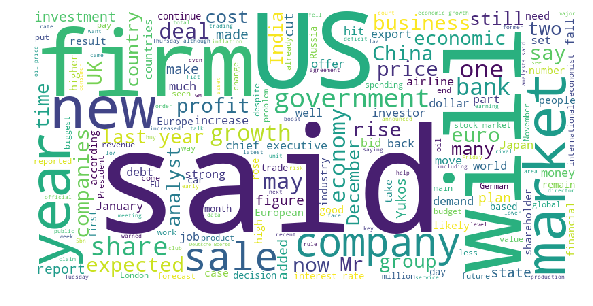

entertainment


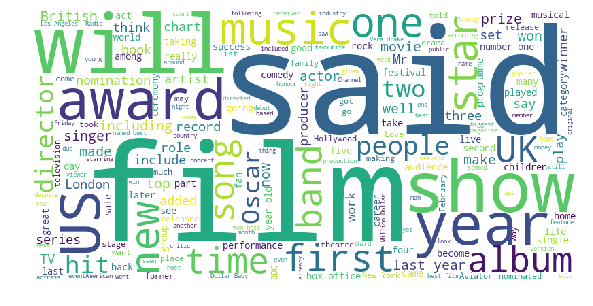

politics


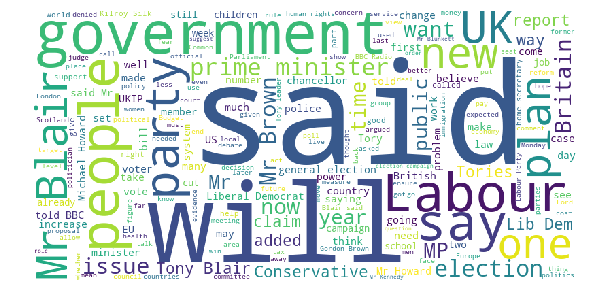

sport


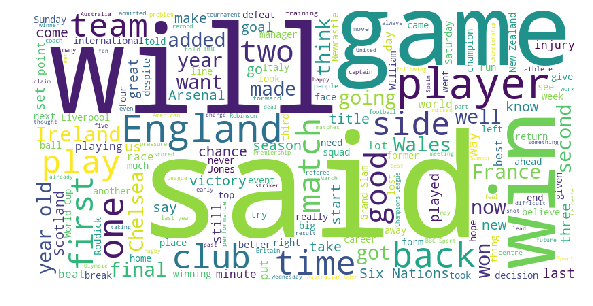

tech


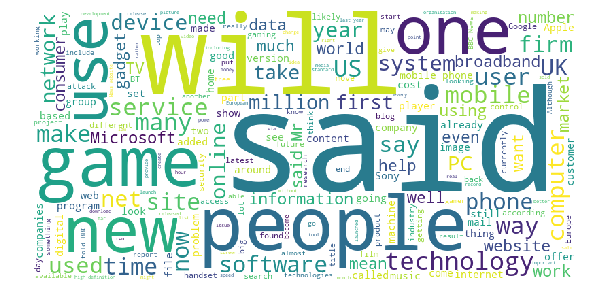

ALL Categories:


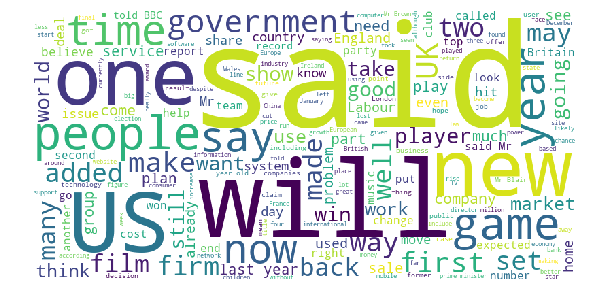

In [8]:

#WordCloud
cat = df['category'].unique()

for i in range(0,len(cat)):
    words = ' '.join(df.loc[df['category']==cat[i], 'text'])

    wordcloud = WordCloud( 
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=800,
                          height=400
                ).generate(words)
    print(cat[i])
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

words = ' '.join(df.loc[:, 'text'])

wordcloud = WordCloud( 
                      stopwords=STOPWORDS,
                      background_color='white',
                      width=800,
                      height=400
            ).generate(words)
print("ALL Categories:")
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


## Label Encoder
#### Use inverse_transform at the end after predicting

In [9]:
#Split training and test set using stratified sampling and test size of 20%
y = df['category']
X = df.drop(['category','id'],axis=1)
X_train, X_test, y_train, y_test  = train_test_split(X,y,stratify=y, test_size=0.2, random_state=123)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print('before: %s ...' %y_train[:5])

#Transform label names to unique number using label encoder
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

print('after: %s ...' %y_train)

before: 1508       sport
1908        tech
2104        tech
2019        tech
1245    politics
Name: category, dtype: object ...
after: [3 4 4 ... 1 0 2] ...


In [10]:
print(np.bincount(y_train))
print(y.value_counts())
print(le.inverse_transform([i for i in range(5)]))

[408 309 333 409 321]
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64
['business' 'entertainment' 'politics' 'sport' 'tech']


## Preprocess Data - (split by \n, remove periods, remove slashes)

In [0]:
#Parameters for hyperparameter  tuning
dropout = 0.3
bidirectional = False
EMBEDDING_DIM = 200
traina = True #embeedding layer trainable

In [0]:
def preprocess(X):
  return X.map(lambda x: x.lower().split("\n")).map(lambda x: [y.split(". ") for y in x]).map(lambda x: [i.replace('\'','') for sl in x for i in sl if i is not ''])

In [0]:
#Preprocess both train and test separately
X_train['text'] = preprocess(X_train['text'])
X_test['text'] = preprocess(X_test['text'])

In [0]:
#Stop Words and Lemmatization   
lemmatizer = WordNetLemmatizer()
stopw = nltk.corpus.stopwords.words('english')
punct = string.punctuation
punct = word_tokenize(punct)
punct += ['.','``','...','\'s','--','-','n\'t','\'']
stopw += punct
def token_stop(text):
    global stopw
    global lemmatizer
    words = word_tokenize(text)
    filtered = [lemmatizer.lemmatize(w) for w in words if not w in stopw]
    return filtered
  
X_train['text'] = X_train['text'].map(lambda x: [token_stop(i) for i in x]).map(lambda x: [i for sl in x for i in sl])
X_test['text'] = X_test['text'].map(lambda x: [token_stop(i) for i in x]).map(lambda x: [i for sl in x for i in sl])

In [0]:
texts = np.array(X_train['text'])
test_text = np.array(X_test['text'])

In [16]:
#Choose max sequence length with optimal sequence length based on box plot
#Load glove model embeddings corresponding to best dimensions from hyperparameter tuning
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
VALIDATION_SPLIT = 0.2
embeddings_index = {}
with open('glove.6B.'+str(EMBEDDING_DIM)+'d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [17]:
#Create data with tokenizer word_index. Neglect words which are not in word_index
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(y_train))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

#Split training and validation data with 20% split. So final is training 64%, validation 16% and test 20% of whole data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

xtrain = data[:-nb_validation_samples]
ytrain = labels[:-nb_validation_samples]
xval = data[-nb_validation_samples:]
yval = labels[-nb_validation_samples:]

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 28682 unique tokens.
Shape of data tensor: (1780, 1000)
Shape of label tensor: (1780, 5)


In [0]:
#Create glove embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
#Keras Glove Embedding layer
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=traina)

In [20]:
#Map label name to its index
labels_index = {}
for i in range(5):
  name = le.inverse_transform([i])[0]
  labels_index[name] = i
labels_index

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

## Train Model

# RNN

In [0]:
#Model Architecture
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
if bidirectional:
  x = Bidirectional(LSTM(100,dropout=dropout))(embedded_sequences)
else:
  x = LSTM(100,dropout=dropout)(embedded_sequences)
preds = Dense(len(labels_index), activation='softmax')(x)
lstm_model = Model(sequence_input, preds)
lstm_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [0]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 200)         5736600   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 5,857,505
Trainable params: 5,857,505
Non-trainable params: 0
_________________________________________________________________


In [0]:
#Callbacks - checkpointer, early stopping and tensorboard
model_name = "RNN-"+str(dropout)+"-"+str(EMBEDDING_DIM)+"-Trainable-"+str(traina)+"-bidrect-"+str(bidirectional)
checkpointer = ModelCheckpoint(model_name + "_weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor="val_loss", verbose=1,
                               save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
tensorboard_rnn = TensorBoard(log_dir='./Graph_RNN', histogram_freq=0,write_graph=True, write_images=True)

In [0]:
#Train Model
stmillis = int(round(time.time() * 1000))
history = lstm_model.fit(xtrain, ytrain, validation_data=(xval, yval),
          epochs=50, batch_size=128, callbacks=[checkpointer, early_stopping,tensorboard_rnn])
endmillis = int(round(time.time() * 1000))
print("Time taken: ", endmillis - stmillis)

Train on 1424 samples, validate on 356 samples
Epoch 1/50
1424/1424 [==============================] - 18s 13ms/step - loss: 1.2277 - acc: 0.5471 - val_loss: 0.6264 - val_acc: 0.8371

Epoch 00001: val_loss improved from inf to 0.62635, saving model to RNN-0.3-200-Trainable-True-bidrect-False_weights.01-0.63.hdf5
Epoch 2/50
1424/1424 [==============================] - 19s 13ms/step - loss: 0.5564 - acc: 0.8441 - val_loss: 0.2954 - val_acc: 0.9101

Epoch 00002: val_loss improved from 0.62635 to 0.29541, saving model to RNN-0.3-200-Trainable-True-bidrect-False_weights.02-0.30.hdf5
Epoch 3/50
1424/1424 [==============================] - 17s 12ms/step - loss: 0.3126 - acc: 0.9080 - val_loss: 0.2490 - val_acc: 0.9438

Epoch 00003: val_loss improved from 0.29541 to 0.24903, saving model to RNN-0.3-200-Trainable-True-bidrect-False_weights.03-0.25.hdf5
Epoch 4/50
1424/1424 [==============================] - 17s 12ms/step - loss: 0.2898 - acc: 0.9164 - val_loss: 0.2234 - val_acc: 0.9354

Epoch 0

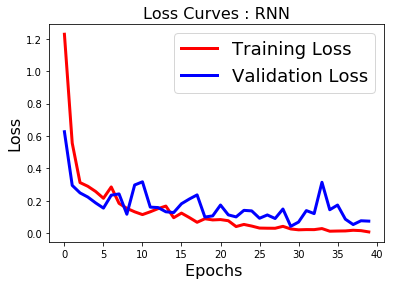

In [0]:
#Plot loss curve
fig=plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves : RNN',fontsize=16)
fig.savefig(model_name+'.png')
plt.show()

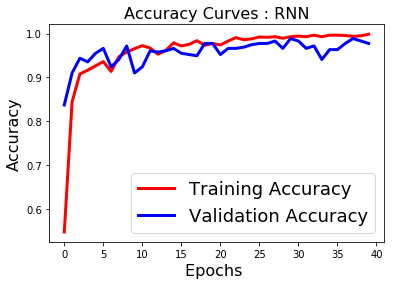

In [0]:
#Plot accuracy curve
fig=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : RNN',fontsize=16)
fig.savefig(model_name+'-ACC'+'.png')
plt.show()

In [0]:
model_name

'RNN-0.3-200-Trainable-True-bidrect-False'

In [0]:
# Save the trained weights
lstm_model.save(model_name + ".h5")

# Save model config as json
model_json = lstm_model.to_json()
with open(model_name + ".json", "w") as json_file:
    json_file.write(model_json)

# Persist the model to your google drive [VERY IMPORTANT]
!cp RNN* gdrive/My\ Drive/

## Predict on Test Data

In [0]:
def find_test_acc(prediction):
  count = 0
  t = 0
  for pred in prediction:
    p = pred.argmax()
    name = le.inverse_transform([p])
    if name == y_test.loc[count]:
      t+=1
    count+=1
  print('Test Accuracy:',(t/count)*100,"%")

In [0]:
def predict_test(model):
  #Tokenize test data and apply model prediction
  sequences = tokenizer.texts_to_sequences(test_text)
  data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

  print('Shape of data tensor:', data.shape)
  print('Shape of label tensor:', labels.shape)
  prediction = model.predict(data)
  find_test_acc(prediction)

In [0]:
!cp gdrive/My\ Drive/RNN-0.3-200-Trainable-True-bidrect-False_weights.30-0.04.hdf5 .
!cp gdrive/My\ Drive/RNN-0.3-200-Trainable-True-bidrect-False.json .

In [0]:
#Load the weights of the model which had the best validation loss
model_filename = 'RNN-0.3-200-Trainable-True-bidrect-False_weights.30-0.04.hdf5'

In [25]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
if bidirectional:
  x = Bidirectional(LSTM(100,dropout=dropout))(embedded_sequences)
else:
  x = LSTM(100,dropout=dropout)(embedded_sequences)
preds = Dense(len(labels_index), activation='softmax')(x)
best_model = Model(sequence_input, preds)

best_model.load_weights(model_filename)

best_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [26]:

#Final test accuracy on the best model
predict_test(best_model)

Shape of data tensor: (445, 1000)
Shape of label tensor: (1780, 5)
Test Accuracy: 95.73033707865169 %


## Tensorboard

In [27]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-05-03 00:53:38--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.232.181.106, 52.204.188.97, 34.206.253.53, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.232.181.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14991793 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  14.30M  41.3MB/s    in 0.3s    

2019-05-03 00:53:38 (41.3 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [14991793/14991793]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [28]:
LOG_DIR = './Graph_RNN'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://c950e1ba.ngrok.io


In [0]:
!cp -r Graph_RNN gdrive/My\ Drive/

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(best_model, to_file='rnn_model.png', show_shapes=True, show_layer_names=True)


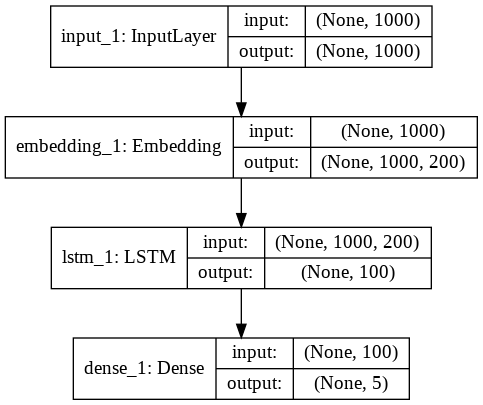

In [32]:
from PIL import Image
display(Image.open('rnn_model.png'))